In [1]:
import os
import tarfile
import urllib.request
import numpy as np

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()


C:\Users\beruk\AppData\Local\Temp\ipykernel_11968\841621550.py:16: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [2]:
#Create test set
import numpy as np

np.random.seed(42)


housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()


In [3]:




from sklearn.impute import SimpleImputer



#Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

#attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
#housing_extra_attribs = attr_adder.transform(housing.values)

housing_num = housing.drop("ocean_proximity", axis=1)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(sparse_output=False), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

     Comparison Table after cross-validation      
--------------------------------------------------
            Model     Mean RMSE    Std RMSE
Linear Regression  69104.079982 2880.328210
    Decision tree  71629.890097 2914.035468
    Random Forest  50435.580921 2203.338141
              SVR 118584.555943 2609.612082


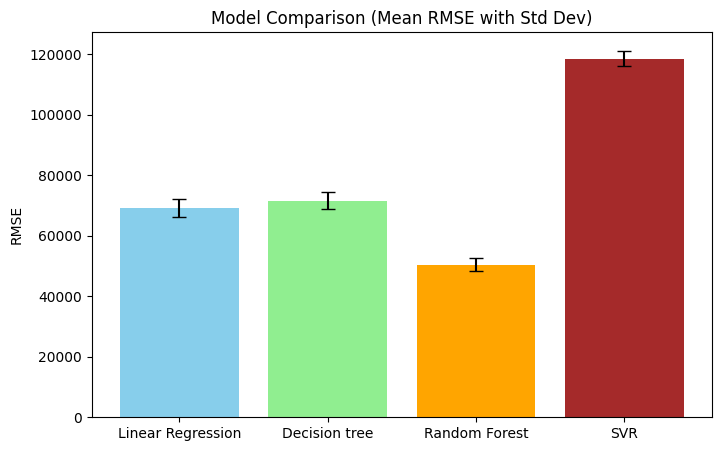

In [ ]:



###################################################
#CROSS-VALIDATION
from sklearn.model_selection import cross_val_score

#Linear Regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

#Decision Tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)


#Random forsest
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)


#SVR
from sklearn.svm import SVR

svm_reg = SVR()
svr_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)

data = {
    "Model": ["Linear Regression","Decision tree", "Random Forest", "SVR"],
    "Mean RMSE": [
        lin_rmse_scores.mean(),
        tree_rmse_scores.mean(),
        forest_rmse_scores.mean(),
        svr_rmse_scores.mean()
    ],
    "Std RMSE": [
        lin_rmse_scores.std(),
        tree_rmse_scores.std(),
        forest_rmse_scores.std(),
        svr_rmse_scores.std()
    ]
}


df = pd.DataFrame(data)


#Tabell
print(f"{'Comparison Table after cross-validation':^50}")
print('-'*50)
print(df.to_string(index=False))

import matplotlib.pyplot as plt
#Figure
plt.figure(figsize=(8,5))
plt.bar(df["Model"],
    df["Mean RMSE"],
    yerr=df["Std RMSE"],
    capsize=5,
    color=["skyblue", "lightgreen", "orange", "brown"]
)


plt.ylabel("RMSE")
plt.title("Model Comparison (Mean RMSE with Std Dev)")
plt.show()



In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


param_grid = {'copy_X': [True,False],
               'fit_intercept': [True,False],
               'n_jobs': [1,5,10,15,None],
               'positive': [True,False]}

lin_reg = LinearRegression()
grid_search = GridSearchCV(lin_reg, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)
best_est_svr = grid_search.best_estimator_
best_para_svr = grid_search.best_params_
final_model_lin = grid_search.best_estimator_
# Parameter which gives the best results
print(f"Best Hyperparameters: {grid_search.best_params_}")
lin_bestscore = grid_search.best_score_
# Accuracy of the model after using best parameters
print(f"Best Score: {np.sqrt(-lin_bestscore)}")

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'positive': False}
Best Score: 69077.320490394


In [6]:
#################FINE TUNING of Models####################
#Gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
#svr
param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)
best_est_svr = grid_search.best_estimator_
best_para_svr = grid_search.best_params_
print('best param for svr:', best_para_svr)
final_model_SVR = grid_search.best_estimator_

#Randomforest
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)
best_est_forest = grid_search.best_estimator_
best_para_forest = grid_search.best_params_
print('best param for random forest:', best_para_forest)
final_model_forest = grid_search.best_estimator_


from sklearn.tree import DecisionTreeRegressor

param_grid = {
    'max_depth': [None, 5, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

tree_reg = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(tree_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           n_jobs=-1)

grid_search.fit(housing_prepared, housing_labels)
best_est_tree = grid_search.best_estimator_
best_para_tree = grid_search.best_params_
print('best param for decision tree:', best_para_tree)
final_model_tree = grid_search.best_estimator_



best param for svr: {'C': 30000.0, 'kernel': 'linear'}
best param for random forest: {'max_features': 8, 'n_estimators': 30}
best param for decision tree: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}


                       RMSE           MAE        R²
SVR            70158.802484  48011.630883  0.632283
Random Forest  19204.663429  12417.613225  0.972447
Decision Tree  50245.694395  34131.492571  0.811397


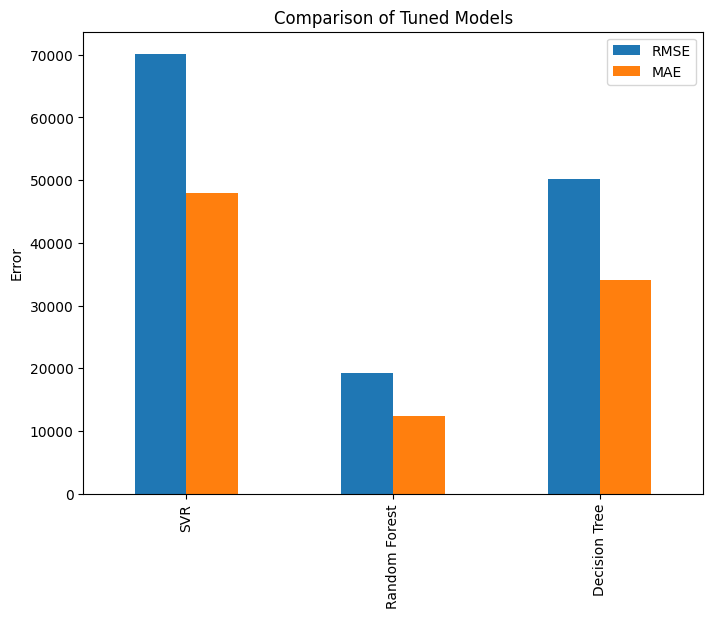

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X, y):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)
    return rmse, mae, r2

# Evaluate all final models on the training set (or better: validation/test set if you have one)
results = {
    "SVR": evaluate_model(final_model_SVR, housing_prepared, housing_labels),
    "Random Forest": evaluate_model(final_model_forest, housing_prepared, housing_labels),
    "Decision Tree": evaluate_model(final_model_tree, housing_prepared, housing_labels)

}


import pandas as pd

df_results = pd.DataFrame(results, index=["RMSE", "MAE", "R²"]).T
print(df_results)

df_results[["RMSE", "MAE"]].plot(kind="bar", figsize=(8,6))
plt.title("Comparison of Tuned Models")
plt.ylabel("Error")
plt.show()

In [ ]:
#Evaluation

from sklearn.metrics import mean_squared_error, mean_absolute_error


X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model_forest.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, final_predictions)

print("Test RMSE:", final_rmse)
print("Test MAE:", final_mae)

Test RMSE: 47873.26095812988
Test MAE: 31811.149475129198


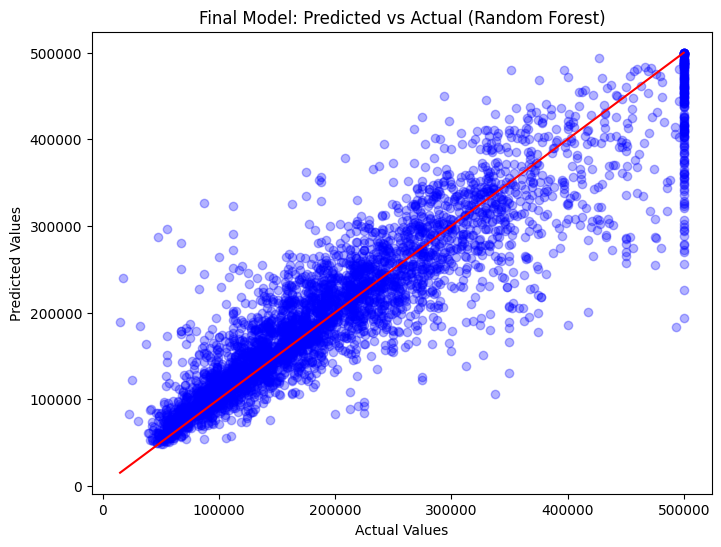

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, final_predictions, alpha=0.3, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c= 'red')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Final Model: Predicted vs Actual (Random Forest)")
plt.show()

In [9]:
from typing_extensions import final
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor


param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)
best_est_forest = rnd_search.best_estimator_
best_para_forest = rnd_search.best_params_
print('best param for random forest:', best_para_forest)
final_model_forest = rnd_search.best_estimator_

from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.
from sklearn.svm import SVR

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

best_est_svr = rnd_search.best_estimator_
best_para_svr = rnd_search.best_params_
print('best param for svr:', best_para_svr)
final_model_SVR = rnd_search.best_estimator_


from sklearn.tree import DecisionTreeRegressor

param_distribs = {
    'max_depth': randint(1, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [None, 'sqrt', 'log2']
}

tree_reg = DecisionTreeRegressor(random_state=42)
rnd_search = RandomizedSearchCV(tree_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                random_state=42, n_jobs=-1)
rnd_search.fit(housing_prepared, housing_labels)

best_est_tree = rnd_search.best_estimator_
best_para_tree = rnd_search.best_params_
print('best param for decision tree:', best_para_tree)

final_model_tree = rnd_search.best_estimator_


best param for random forest: {'max_features': 7, 'n_estimators': 180}
best param for svr: {'C': np.float64(157055.10989448498), 'gamma': np.float64(0.26497040005002437), 'kernel': 'rbf'}
best param for decision tree: {'max_depth': 49, 'max_features': None, 'min_samples_leaf': 17, 'min_samples_split': 3}


                       RMSE           MAE        R²
SVR            48464.349556  29226.505673  0.824533
Random Forest  18087.061753  11869.014209  0.975561
Decision Tree  47230.054557  31197.890966  0.833357


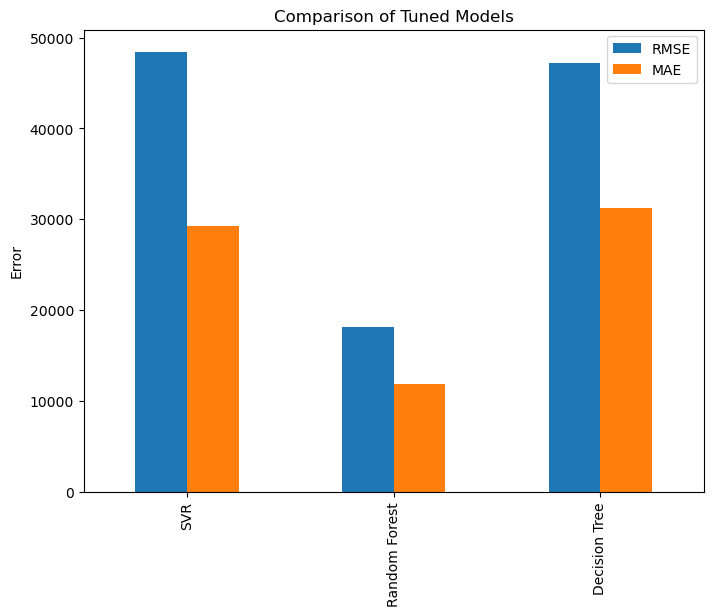

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X, y):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)
    return rmse, mae, r2

# Evaluate all final models on the training set (or better: validation/test set if you have one)
results = {
    "SVR": evaluate_model(final_model_SVR, housing_prepared, housing_labels),
    "Random Forest": evaluate_model(final_model_forest, housing_prepared, housing_labels),
    "Decision Tree": evaluate_model(final_model_tree, housing_prepared, housing_labels)

}


import pandas as pd

df_results = pd.DataFrame(results, index=["RMSE", "MAE", "R²"]).T
print(df_results)

df_results[["RMSE", "MAE"]].plot(kind="bar", figsize=(8,6))
plt.title("Comparison of Tuned Models")
plt.ylabel("Error")
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model_forest.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, final_predictions)

print("Test RMSE:", final_rmse)
print("Test MAE:", final_mae)

Test RMSE: 46981.841079394515
Test MAE: 31290.499060615846
